In [16]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/Documents/GitHub/Master-Degree


In [4]:
#Reading and defining data of simulation
#All values are stored in the original jam_axi_rms_example.py and in the text files present in this folder
#To know: mge.txt; other_parameters.txt; vrm.txt


surf_lum, sigma_lum, qobs_lum = np.loadtxt("mge.txt", unpack=True)         #Reading data of MGE
inc_dat      = 60.          #galaxy inclination (only for dynamical model) [deg]       
mbh_dat      = 1e8          #black hole mass   [M_sun]
ML_dat       = 1.2          #mass to light ratio [M_sun/L_sun]
distance_dat = 16.5         #distance to source galaxy (for redshift) [Mpc]
qSMBH        = 1.           #Assuming a circular gaussian for bh [ad]
sigma_bh     = 0.01         #Assuming sigma for bh [arcsec]

In [6]:
#Lens parameters

z = z_at_value(cosmo.angular_diameter_distance, distance_dat * u.Mpc, zmax=1.0) #Convert distance to redshifth 
z_lens = z                                    #Lens redshift
z_source = 2.1                                #Source redshift

## Starting model

To simulate an image, we need to model the telescope’s optics. We’ll do this by convolving the image with a Point-Spread Function using a Kernel object, which we can simulate as a Gaussian. We also simulated a grid

In [8]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

grid = al.Grid.uniform(shape_2d=(85, 85), pixel_scales=0.1, sub_size=1)

Now, lets setup our lens galaxy, source galaxy and Tracer.

In [18]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE(gamma=3)
""" 
    We are assuming gamma=3 because in the last simulation there was an error in this 
    parameters during the deflection. There, we multiply the deflection angle by (1 + gamma). 
    But, the correct factor is 0.5 * (1 + gamma). So, to compare the actual implementation with 
    the previous one it is necessary to compensate this erro.
"""

#Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ML_dat,
                       mbh=mbh_dat, sigma_mbh=sigma_bh, qobs_mbh=qSMBH)

#Grid
mass_profile.MGE_Grid_parameters(grid)

In [19]:
#Lens galaxy

shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=142) #external shear

lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [20]:
#Source galaxy
source_galaxy = al.Galaxy(
    redshift=z_source,
    bulge=al.lp.EllipticalSersic(
        centre=(0, 0.8),
        elliptical_comps=(0.3, 0.111111),
        intensity=5.0,
        effective_radius=0.5,
        sersic_index=0.8,
    ),
)

In [21]:
#Tracing the deflection angles
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

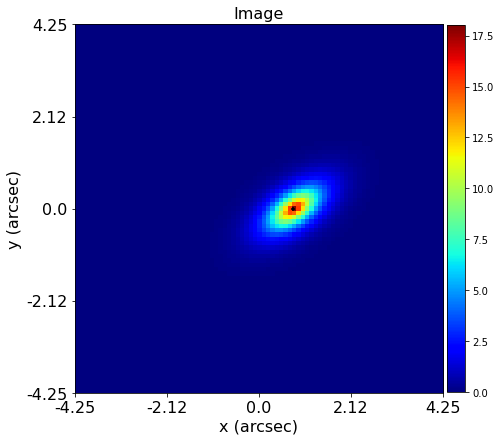

In [22]:
#Ploting our source galaxy
plotter = aplt.Plotter(
    figure=aplt.Figure(figsize=(7, 7)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),
)
#output=aplt.Output(filename="Souce_galaxy.fits", format="fits")
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)

Lets look at the Tracer’s image - this is the image we’ll be simulating.

Critical curve could not be calculated due to an unphysical mass model


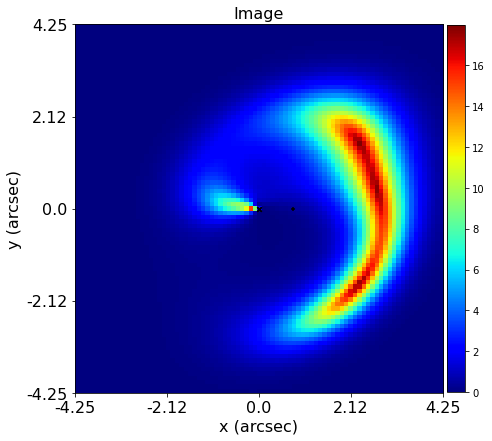

9.333812457000022


In [23]:
time = clock()
aplt.Tracer.image(tracer=tracer, grid=grid)
print(clock() - time)

To Simulate the Imaging data, we don’t use the image plotted above. Instead, we use an image which has been generated specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we convolve the image with. This ensures edge-effects do not degrade our simulation’s PSF convolution

In [25]:
time = clock()

normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

print(clock() - time)

(7225,)
(9025,)
21.32612848500048


Now, to simulate the Imaging data, we pass the Tracer and Grid to the Imaging module’s simulate function. This adds the following effects to the image:


    Telescope optics: Using the Point Spread Function above.
    The Background Sky: Although the image that is returned is automatically background sky subtracted.
    Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.


In [26]:
time = clock()

simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

print(clock() - time)

13.49242709200007


Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

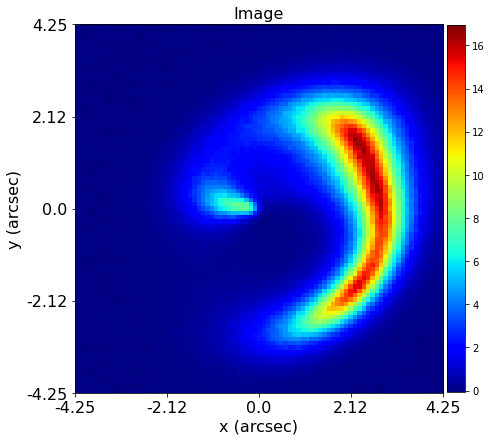

In [27]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files.

In [28]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/Autolens_tests/autolens_workspace/Test_MGE_Class/Data_new"
print("Dataset Path: ", dataset_path)


Dataset Path:  /home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_MGE_Class/Data


In [31]:
imaging.output_to_fits(
    image_path=f"{dataset_path}/image_test.fits",
    noise_map_path=f"{dataset_path}/noise_test.fits",
    psf_path=f"{dataset_path}/psf_test.fits",
    overwrite=True,
)

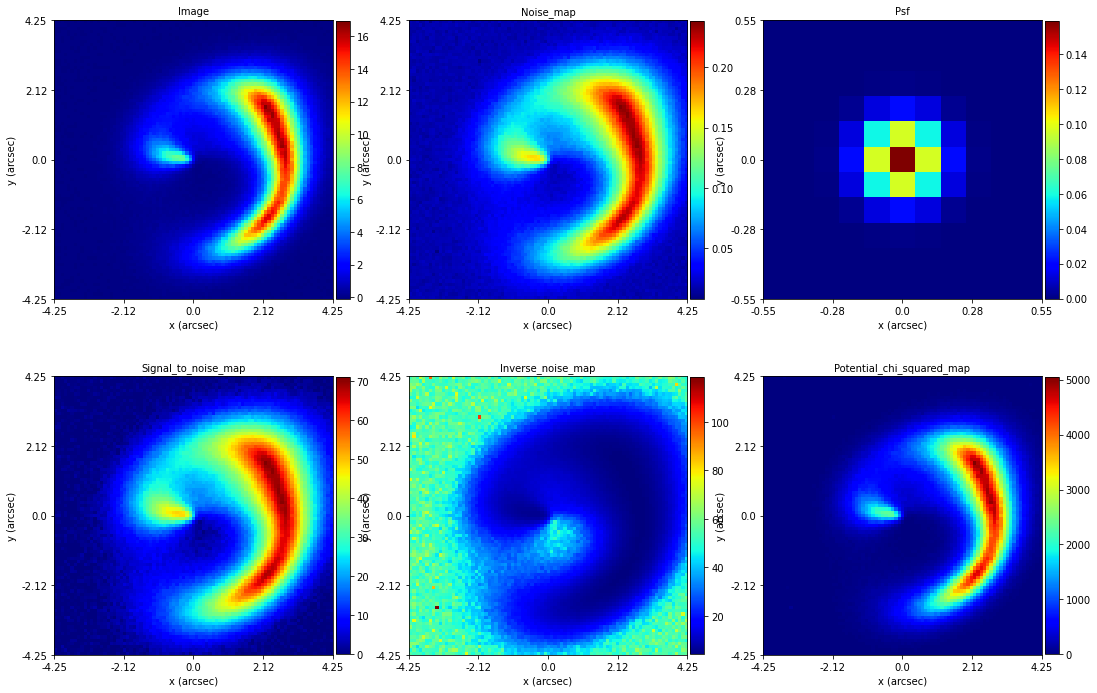

In [33]:
#Load data
imaging = al.Imaging.from_fits(
        image_path=f"{dataset_path}/image_test.fits",
        noise_map_path=f"{dataset_path}/noise_test.fits",
        psf_path=f"{dataset_path}/psf_test.fits",
        pixel_scales=0.1,
    )

aplt.Imaging.subplot_imaging(imaging)